<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
C:\Users\86153\AppData\Local\Temp\ipykernel_8236\2710293062.py:11: SyntaxWarning: invalid escape sequence '\s'
  dfCO2te = pd.read_csv('global.1751_2014.ems', sep='\s+', skiprows=33).iloc[:,0:2]


         Total
Year          
1751  0.001408
1752  0.001408
1753  0.001408
1754  0.001408
1755  0.001408
...        ...
2010  4.285446
2011  4.461502
2012  4.541315
2013  4.588263
2014  4.626761

[264 rows x 1 columns]


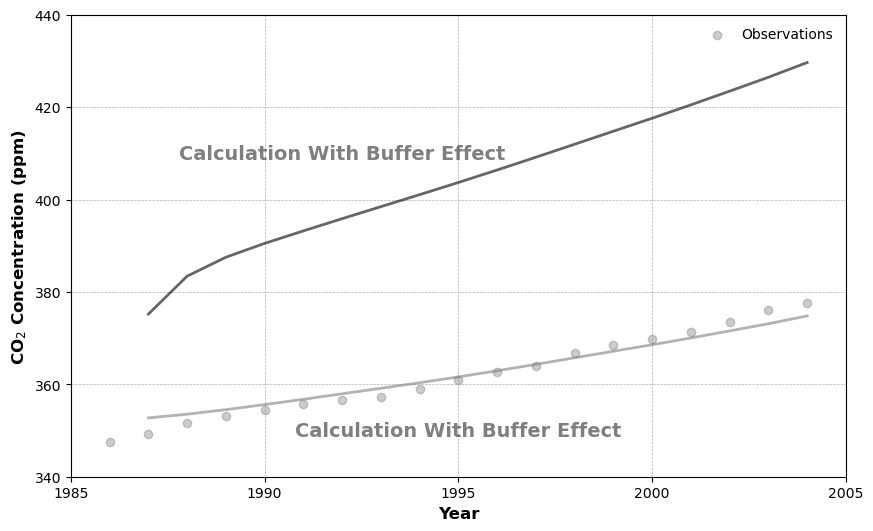

In [77]:
import pandas as pd
import numpy as np
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt

%matplotlib inline

# PS5-1
# 加载并筛选数据
dfCO2te = pd.read_csv('global.1751_2014.ems', sep='\s+', skiprows=33).iloc[:,0:2]
dfCO2te.set_index('Year', inplace=True)
dfCO2te

# 单位换算为ppm
dfCO2te = dfCO2te * 1e-3 / 2.13
print(dfCO2te)

# 提取并筛选站点的观测值
MLCO2ov = pd.read_csv('co2_annmean_mlo.csv', skiprows=43).iloc[:,0:2]
MLCO2ov.set_index('year', inplace=True)
MLCO2ov.loc[1986:2004] 

# 无缓冲效应的模型
def model_0(N, t, k12, k21, gamma_t):
    N1, N2 = N
    dN1_dt = -k12 * N1 + k21 * N2 + gamma_t
    dN2_dt = k12 * N1 - k21 * N2
    return [dN1_dt, dN2_dt]

# 有缓冲效应的模型
def model_1(N, t, k12, k21, gamma_t, N2_pre):
    N1, N2 = N
    xi = 3.69 + 1.86 * 10**(-2) * N1 - 1.80 * 10**(-6) * N1**2 # 基于公式A9计算缓冲因子
    dN1_dt = -k12 * N1 + k21 * (N2_pre + xi * (N2 - N2_pre)) + gamma_t
    dN2_dt = k12 * N1 - k21 * (N2_pre + xi * (N2 - N2_pre))
    return [dN1_dt, dN2_dt]

# 传输系数计算
k12 = 105 / 740
k21 = 102 / 900

# 初始条件
N1_0 = 750 / 2.13 # 1987年大气中的碳浓度
N2_0 = 900 / 2.13 # 1987年海洋表面的碳浓度
N2_pre_ppm = 821 / 2.13

# 计算从1987至2004的数据, 后一年数据由前一年得出
year = np.arange(1986, 2004, 1) 

# 创建空白数组用于存放模型计算结果
N_0 = np.zeros((len(year)+1, 2))
N_1 = np.zeros((len(year)+1, 2))
N_0[0] = [N1_0, N2_0] 
N_1[0] = [N1_0, N2_0]

# 求解微分方程
for t in year:
    gamma = dfCO2te.loc[t,'Total']
    N_0[t+1-year[0]] = odeint(model_0,N_0[t-year[0]],np.array([t,t+1]),args=(k12, k21, gamma))[-1]
    N_1[t+1-year[0]] = odeint(model_1,N_1[t-year[0]],np.array([t,t+1]),args=(k12, k21, gamma, N2_pre_ppm))[-1]

# PLOT
plt.figure(figsize=(10, 6))
plt.plot(year+1, N_0[1:, 0], color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(year+1, N_1[1:, 0], color='black', linestyle='-', linewidth=2, alpha=0.6)
plt.scatter(MLov.loc[1986:2004].index, MLov.loc[1986:2004].values, color='grey', label='Observations', zorder=3, alpha=0.4)
plt.text(1992, 410, 'Calculation With Buffer Effect', fontsize=14, color='black',fontweight='bold',ha='center', va='center',alpha=0.5)
plt.text(1995, 350, 'Calculation With Buffer Effect', fontsize=14, color='black',fontweight='bold',ha='center', va='center',alpha=0.5)
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('CO$_2$ Concentration (ppm)', fontsize=12, fontweight='bold')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', frameon=False)
plt.xticks(np.arange(1985, 2008, 5), fontsize=10)
plt.yticks(np.arange(340, 441, 20), fontsize=10)

#保存并显示图片
plt.savefig('PS5-1plot.png')
plt.show()
